In [1]:
# !pip -q install transformers sentencepiece rouge nltk==3.6.2

In [2]:
# !wget -q https://storage.googleapis.com/tabqgen/tabqgen_processed_csv.zip

In [3]:
# !unzip tabqgen_processed_csv.zip -d ./datasets/

In [1]:
!nvidia-smi

Mon Jun 14 15:31:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
datasets = './datasets/'

In [3]:
save_path = './'

In [4]:
from transformers import get_linear_schedule_with_warmup, AdamW, T5TokenizerFast, T5ForConditionalGeneration
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import time, datetime
import nltk
from rouge import Rouge
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# nltk.download('wordnet')

In [6]:
rouge_calculator = Rouge()

In [7]:
tokenizer = T5TokenizerFast.from_pretrained("t5-small")

In [8]:
model = T5ForConditionalGeneration.from_pretrained("t5-small").cuda()

In [9]:
totto_tokens = {'additional_special_tokens': ['<page_title>', '</page_title>', 
                                           '<section_title>', '</section_title>',
                                           '<table>', '</table>',
                                           '<cell>', '</cell>',
                                           '<col_header>', '</col_header>',
                                           '<highlighted_cell>','</highlighted_cell>',
                                           '<row>','</row>',
                                           '<row_header>','</row_header>',]}

In [10]:
tokenizer.add_special_tokens(totto_tokens)

16

In [11]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32116, 512)

In [12]:
df = pd.read_csv(f'{datasets}/tabqgen_train.csv')

In [13]:
train, val = train_test_split(df, test_size=0.0828, random_state=42)

In [14]:
train.shape, val.shape

((110761, 4), (10000, 4))

In [15]:
train.columns, val.columns

(Index(['Unnamed: 0', 'subtable_text', 'label', 'questions'], dtype='object'),
 Index(['Unnamed: 0', 'subtable_text', 'label', 'questions'], dtype='object'))

In [16]:
train.drop(columns = ['Unnamed: 0'], inplace = True)
val.drop(columns = ['Unnamed: 0'], inplace = True)

/home/ubuntu/anaconda3/envs/torch/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
train_input_txt = train.subtable_text.values
train_target_txt = train.questions.values

val_input_txt = val.subtable_text.values
val_target_txt = val.questions.values

In [18]:
def encode_input(inp_txt):
    enc_inp_ids = []
    enc_inp_attn_mask = []

    for in_txt in tqdm_notebook(inp_txt):
        enc_input = tokenizer.encode_plus(in_txt, 
                                      add_special_tokens=True,
                                      max_length = 512,
                                      truncation = True,
                                      return_tensors = 'pt',
                                      return_attention_mask=True,
                                      return_token_type_ids=False,
                                      padding = 'max_length')
        enc_inp_ids.append(enc_input.input_ids)
        enc_inp_attn_mask.append(enc_input.attention_mask)

    enc_inp_ids = torch.cat(enc_inp_ids, dim = 0)
    enc_attn_mask = torch.cat(enc_inp_attn_mask, dim = 0)
    
    return(enc_inp_ids, enc_attn_mask)

In [19]:
def encode_target(targ_txt):
    enc_out_ids = []
    enc_out_attn_mask = []

    for trg_txt in tqdm_notebook(targ_txt):
        enc_output = tokenizer.encode_plus(trg_txt, 
                                       add_special_tokens=True,
                                       max_length=64,
                                       return_tensors='pt',
                                       return_attention_mask=True,
                                       return_token_type_ids=False,
                                       padding = 'max_length',
                                       truncation =True)

        enc_out_ids.append(enc_output.input_ids)
        enc_out_attn_mask.append(enc_output.attention_mask)

    enc_out_ids = torch.cat(enc_out_ids, dim = 0)
    enc_out_attn_mask = torch.cat(enc_out_attn_mask, dim = 0)
    
    return(enc_out_ids, enc_out_attn_mask)

In [20]:
enc_inp_ids, enc_attn_mask = encode_input(train_input_txt)
dec_inp_ids, dec_attn_mask = encode_target(train_target_txt)


train_ds = TensorDataset(enc_inp_ids, enc_attn_mask,
                  dec_inp_ids, dec_attn_mask, dec_inp_ids)


val_enc_inp_ids, val_enc_attn_mask = encode_input(val_input_txt)
val_dec_inp_ids, val_dec_attn_mask = encode_target(val_target_txt)

val_ds = TensorDataset(val_enc_inp_ids, val_enc_attn_mask,
                  val_dec_inp_ids, val_dec_attn_mask, val_dec_inp_ids)

  0%|          | 0/110761 [00:00<?, ?it/s]

  0%|          | 0/110761 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
tokenizer.decode(dec_inp_ids[1], skip_special_tokens=True)

'What was the highest temperature ever recorded in Humboldt?'

In [22]:
print('Train dataset shapes: {}, {}'.format(enc_inp_ids.shape, dec_inp_ids.shape))
print('Val dataset shapes: {}, {}'.format(val_enc_inp_ids.shape, val_dec_inp_ids.shape))

Train dataset shapes: torch.Size([110761, 512]), torch.Size([110761, 64])
Val dataset shapes: torch.Size([10000, 512]), torch.Size([10000, 64])


In [23]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE)
val_dataloader = DataLoader(val_ds, batch_size = BATCH_SIZE)

In [24]:
EPOCHS = 10

steps = len(train_dataloader) * EPOCHS

optimizer = AdamW(model.parameters(), lr = 1e-4, eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = 0,
                                           num_training_steps=steps)

In [25]:
def tot_bleu(ref_list_, pred_list_):
    ref_list = []
    pred_list = []
    for idx, pred in enumerate(pred_list_):
        if not len(pred.split())<=1:
          ref_list.append(ref_list_[idx])
          pred_list.append(pred_list_[idx])
    if pred_list:
      bleu = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_list)
      return bleu
    else:
      return 0

In [26]:
def tot_nist(ref_list_, pred_list_):
    ref_list = []
    pred_list = []
    for idx, pred in enumerate(pred_list_):
        if not len(pred.split())<=1:
          ref_list.append(ref_list_[idx])
          pred_list.append(pred_list_[idx])
    
    if pred_list:
      nist = nltk.translate.nist_score.corpus_nist(ref_list, pred_list)
      return nist
    else:
      return 0

In [27]:
def tot_rouge(ref_list_, pred_list_):
    ref_list = []
    pred_list = []
    for idx, pred in enumerate(pred_list_):
        if not len(pred.split())<=1:
          ref_list.append(ref_list_[idx])
          pred_list.append(pred_list_[idx])
    if pred_list:
      rouge_score = rouge_calculator.get_scores(pred_list, ref_list, avg=True, ignore_empty=True)
      return rouge_score['rouge-l']['f']
    else:
      return 0

In [28]:
def tot_meteor(ref_list, pred_list):
    # print(len(pred_list))
    meteor_list = []
    for idx in range(len(ref_list)):
        if len(pred_list[idx].split())<=1:
          meteor_list.append(0)
        else:
          meteor_list.append(nltk.translate.meteor_score.meteor_score(ref_list[idx], pred_list[idx]))
    return sum(meteor_list)/len(meteor_list)

In [29]:
def compute_metrics(logits, gold):
    preds = tokenizer.batch_decode(np.argmax(logits,axis=-1), skip_special_tokens=True)
    labels = tokenizer.batch_decode(gold, skip_special_tokens=True)
    corpus_refs = [[i] for i in labels]
    
    bbleu = tot_bleu(corpus_refs, preds)
    bnist = tot_nist(corpus_refs, preds)
    brouge = tot_rouge(labels, preds)
    bmeteor = tot_meteor(corpus_refs, preds)
    
    return bbleu, bnist, brouge, bmeteor

In [30]:
def write_to_file(epoch, avg_train_loss, avg_vall_loss, avg_bleu_score, val_avg_bleu_score, avg_nist_score, val_avg_nist_score, avg_rouge_score, val_avg_rouge_score, avg_meteor_score, val_avg_meteor_score, training_time, validation_time, logits, gold):
    pred_str = tokenizer.batch_decode(np.argmax(logits,axis=-1), skip_special_tokens=True)
    label_str = tokenizer.batch_decode(gold, skip_special_tokens=True)
    with open('log.txt', 'a') as f:
        f.write(f'Epoch: {epoch + 1}; Avg Train Loss: {avg_train_loss}; Avg Val Loss: {avg_val_loss}; \
                Avg Train BLEU:{avg_bleu_score}; Avg Validation BLEU:{val_avg_bleu_score}; \
                Avg Train NIST:{avg_nist_score}; Avg Validation NIST:{val_avg_nist_score}; \
                Avg Train ROUGE:{avg_rouge_score}; Avg Validation ROUGE:{val_avg_rouge_score}; \
                Avg Train METEOR:{avg_meteor_score}; Avg Validation METEOR:{val_avg_meteor_score}; \
                Training Time: {training_time}; Validation Time: {validation_time}\n\n')
        for i in range(len(pred_str)):
            f.write(f"TARGET    >>> {label_str[i]}\n")
            f.write(f"PREDICTED >>> {pred_str[i]}\n\n")
        f.write('\n')
        f.write(120 * '~')
        f.write('\n')

In [31]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
training_stats = []
best_accuracy = 0
best_loss = 100   # dummy value

hist_loss = []
hist_bleu_scores = []
hist_nist_scores = []
hist_rouge_scores = []
hist_meteor_scores = []

val_hist_loss = []
val_hist_bleu_scores = []
val_hist_nist_scores = []
val_hist_rouge_scores = []
val_hist_meteor_scores = []

for epoch in range(EPOCHS):
    
    t0 = time.time()
    
    total_blue = 0
    total_nist = 0
    total_rouge = 0
    total_meteor = 0
    
    print(20 * "-" + " EPOCH {} / {} ".format(epoch+1, EPOCHS) + 20 * "-")
    print(10 * "=" + " TRAINING " + 10 * "=")
    
    total_train_loss = 0
    
    model.train()
    
    for nth_batch, batch in tqdm_notebook(enumerate(train_dataloader), total = len(train_dataloader)):       
        inp_ids = batch[0].to('cuda')
        inp_mask = batch[1].to('cuda')
        decoder_input_ids = batch[2].to('cuda')
        decoder_attention_mask = batch[3].to('cuda')
        gold = batch[4].to('cuda')
        
        model.zero_grad()
        
        train_output = model(input_ids = inp_ids, attention_mask = inp_mask, labels = gold)
        
        loss = train_output.loss
        logits = train_output.logits
        
        total_train_loss += loss.item()
        
        bleu, nist, rouge, meteor = compute_metrics(logits.detach().cpu().numpy(), gold.detach().cpu().numpy())
        
        total_blue+=bleu
        total_nist+=nist
        total_rouge+=rouge
        total_meteor+=meteor
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_bleu_score = total_blue / len(train_dataloader)
    avg_nist_score = total_nist / len(train_dataloader)
    avg_rouge_score = total_rouge / len(train_dataloader)
    avg_meteor_score = total_meteor / len(train_dataloader)
    
    training_time = format_time(time.time() - t0)
    
    hist_loss.append(avg_train_loss)
    hist_bleu_scores.append(avg_bleu_score)
    hist_nist_scores.append(avg_nist_score)
    hist_rouge_scores.append(avg_rouge_score)
    hist_meteor_scores.append(avg_meteor_score)
    
    print("\n>>>>> Average Train Loss : {}".format(str(avg_train_loss)))
    print("\n>>>>> Average Train BLEU Score : {}".format(str(avg_bleu_score)))
    print("\n>>>>> Average Train NIST Score : {}".format(str(avg_nist_score)))
    print("\n>>>>> Average Train ROUGE Score : {}".format(str(avg_rouge_score)))
    print("\n>>>>> Average Train METEOR Score : {}".format(str(avg_meteor_score)))
    
    

    print(10*"=" + " VALIDATION " + 10*"=")
    total_val_loss = 0

    model.eval()
    
    val_total_blue = 0
    val_total_nist = 0
    val_total_rouge = 0
    val_total_meteor = 0
    
    t0 = time.time()

    for nth_batch, batch in tqdm_notebook(enumerate(val_dataloader), total = len(val_dataloader)):
        inp_ids = batch[0].to('cuda')
        inp_mask = batch[1].to('cuda')
        decoder_input_ids = batch[2].to('cuda')
        decoder_attention_mask = batch[3].to('cuda')
        gold = batch[2].to('cuda')

        with torch.no_grad():

            val_output = model(input_ids = inp_ids, attention_mask = inp_mask,labels = gold)

            loss = val_output.loss
            logits = val_output.logits

        total_val_loss += loss.item()

        bleu, nist, rouge, meteor = compute_metrics(logits.detach().cpu().numpy(), gold.detach().cpu().numpy())
        
        val_total_blue+=bleu
        val_total_nist+=nist
        val_total_rouge+=rouge
        val_total_meteor+=meteor


    avg_val_loss = total_val_loss / len(val_dataloader)
    val_avg_bleu_score = val_total_blue / len(val_dataloader)
    val_avg_nist_score = val_total_nist / len(val_dataloader)
    val_avg_rouge_score = val_total_rouge / len(val_dataloader)
    val_avg_meteor_score = val_total_meteor / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)

    val_hist_loss.append(avg_val_loss)
    val_hist_bleu_scores.append(val_avg_bleu_score)
    val_hist_nist_scores.append(val_avg_nist_score)
    val_hist_rouge_scores.append(val_avg_rouge_score)
    val_hist_meteor_scores.append(val_avg_meteor_score)
    
    print("\n>>>>> Average Validation Loss : {}".format(str(avg_val_loss)))
    print("\n>>>>> Average Validation BLEU Score : {}".format(str(val_avg_bleu_score)))
    print("\n>>>>> Average Validation NIST Score : {}".format(str(val_avg_nist_score)))
    print("\n>>>>> Average Validation ROUGE Score : {}".format(str(val_avg_rouge_score)))
    print("\n>>>>> Average Validation METEOR Score : {}".format(str(val_avg_meteor_score)))
    
    write_to_file(epoch, avg_train_loss, avg_val_loss, avg_bleu_score, val_avg_bleu_score, avg_nist_score, val_avg_nist_score, avg_rouge_score, val_avg_rouge_score, avg_meteor_score, val_avg_meteor_score, training_time, validation_time, logits.detach().cpu().numpy(), gold.detach().cpu().numpy())    

-------------------- EPOCH 1 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.2911716180383849

>>>>> Average Train BLEU Score : 0.6525057585001892

>>>>> Average Train NIST Score : 7.030661594890135

>>>>> Average Train ROUGE Score : 0.5846166426538695

>>>>> Average Train METEOR Score : 0.526577953889256
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.20139013140346296

>>>>> Average Validation BLEU Score : 0.7143575261660358

>>>>> Average Validation NIST Score : 7.550471047828741

>>>>> Average Validation ROUGE Score : 0.6609583507402158

>>>>> Average Validation METEOR Score : 0.6147564320163759
-------------------- EPOCH 2 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.21693669986959002

>>>>> Average Train BLEU Score : 0.6977589724398885

>>>>> Average Train NIST Score : 7.428369077644386

>>>>> Average Train ROUGE Score : 0.6404240256224951

>>>>> Average Train METEOR Score : 0.5909698566632517
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.18670308435210786

>>>>> Average Validation BLEU Score : 0.7296841158079839

>>>>> Average Validation NIST Score : 7.666262361961808

>>>>> Average Validation ROUGE Score : 0.6797282572284508

>>>>> Average Validation METEOR Score : 0.636218008760176
-------------------- EPOCH 3 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.20066695379288055

>>>>> Average Train BLEU Score : 0.7124099213134958

>>>>> Average Train NIST Score : 7.550578761234329

>>>>> Average Train ROUGE Score : 0.6583306471114603

>>>>> Average Train METEOR Score : 0.6111988519096789
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.1799951439229444

>>>>> Average Validation BLEU Score : 0.7374850005881874

>>>>> Average Validation NIST Score : 7.73298458603237

>>>>> Average Validation ROUGE Score : 0.6889800167237435

>>>>> Average Validation METEOR Score : 0.6468630737404809
-------------------- EPOCH 4 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.18968820256616323

>>>>> Average Train BLEU Score : 0.7224272014554061

>>>>> Average Train NIST Score : 7.635935862863702

>>>>> Average Train ROUGE Score : 0.6703064578318803

>>>>> Average Train METEOR Score : 0.6251093775650669
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.17482342623388425

>>>>> Average Validation BLEU Score : 0.7434181507878136

>>>>> Average Validation NIST Score : 7.784113148092434

>>>>> Average Validation ROUGE Score : 0.6954543538518142

>>>>> Average Validation METEOR Score : 0.654541883534044
-------------------- EPOCH 5 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.18168210364761964

>>>>> Average Train BLEU Score : 0.7301806149604472

>>>>> Average Train NIST Score : 7.701313144849515

>>>>> Average Train ROUGE Score : 0.6792966067745839

>>>>> Average Train METEOR Score : 0.6354477094603254
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.17231893222838546

>>>>> Average Validation BLEU Score : 0.7458717509579261

>>>>> Average Validation NIST Score : 7.805389458702128

>>>>> Average Validation ROUGE Score : 0.6990877922347534

>>>>> Average Validation METEOR Score : 0.658193061631212
-------------------- EPOCH 6 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.1747375394178394

>>>>> Average Train BLEU Score : 0.7364017687991253

>>>>> Average Train NIST Score : 7.754990830240968

>>>>> Average Train ROUGE Score : 0.6865042602405773

>>>>> Average Train METEOR Score : 0.643786119720037
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.169774089187098

>>>>> Average Validation BLEU Score : 0.7494781622210773

>>>>> Average Validation NIST Score : 7.829519931126639

>>>>> Average Validation ROUGE Score : 0.7030459232747933

>>>>> Average Validation METEOR Score : 0.6635445485666303
-------------------- EPOCH 7 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.16911648071609364

>>>>> Average Train BLEU Score : 0.7423700084402696

>>>>> Average Train NIST Score : 7.80562156597771

>>>>> Average Train ROUGE Score : 0.6937389710886119

>>>>> Average Train METEOR Score : 0.6522297615519754
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.16795524807212453

>>>>> Average Validation BLEU Score : 0.7512488241714387

>>>>> Average Validation NIST Score : 7.842650326678686

>>>>> Average Validation ROUGE Score : 0.7044052973530184

>>>>> Average Validation METEOR Score : 0.6648033437107975
-------------------- EPOCH 8 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.16406973884379086

>>>>> Average Train BLEU Score : 0.7472800820566382

>>>>> Average Train NIST Score : 7.8490511730060195

>>>>> Average Train ROUGE Score : 0.6991750372543525

>>>>> Average Train METEOR Score : 0.6583085453949683
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.16684400054593437

>>>>> Average Validation BLEU Score : 0.7529785337572602

>>>>> Average Validation NIST Score : 7.862854955363874

>>>>> Average Validation ROUGE Score : 0.7074136821780184

>>>>> Average Validation METEOR Score : 0.6682990868423034
-------------------- EPOCH 9 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.1595250086408003

>>>>> Average Train BLEU Score : 0.7517085346575075

>>>>> Average Train NIST Score : 7.8857237856855384

>>>>> Average Train ROUGE Score : 0.703995534561142

>>>>> Average Train METEOR Score : 0.6643959470868829
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.16636037488524524

>>>>> Average Validation BLEU Score : 0.7542471556950647

>>>>> Average Validation NIST Score : 7.87052677142756

>>>>> Average Validation ROUGE Score : 0.708485331042676

>>>>> Average Validation METEOR Score : 0.668905372471289
-------------------- EPOCH 10 / 10 --------------------
========== TRAINING ==========


  0%|          | 0/3462 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.15558672137235643

>>>>> Average Train BLEU Score : 0.755986202209382

>>>>> Average Train NIST Score : 7.922667362657761

>>>>> Average Train ROUGE Score : 0.7097307533859544

>>>>> Average Train METEOR Score : 0.6708092604490119
========== VALIDATION ==========


  0%|          | 0/313 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.16532957446746552

>>>>> Average Validation BLEU Score : 0.7557411452522905

>>>>> Average Validation NIST Score : 7.886340299734235

>>>>> Average Validation ROUGE Score : 0.7106395122456595

>>>>> Average Validation METEOR Score : 0.6717461598751631


In [33]:
%%time
model.save_pretrained('table_qgen')

CPU times: user 217 ms, sys: 193 ms, total: 409 ms
Wall time: 415 ms


In [34]:
tokenizer.save_pretrained('table_qgen')

('table_qgen/tokenizer_config.json',
 'table_qgen/special_tokens_map.json',
 'table_qgen/spiece.model',
 'table_qgen/added_tokens.json',
 'table_qgen/tokenizer.json')

In [35]:
hist_loss

[0.2911716180383849,
 0.21693669986959002,
 0.20066695379288055,
 0.18968820256616323,
 0.18168210364761964,
 0.1747375394178394,
 0.16911648071609364,
 0.16406973884379086,
 0.1595250086408003,
 0.15558672137235643]

In [36]:
val_hist_loss

[0.20139013140346296,
 0.18670308435210786,
 0.1799951439229444,
 0.17482342623388425,
 0.17231893222838546,
 0.169774089187098,
 0.16795524807212453,
 0.16684400054593437,
 0.16636037488524524,
 0.16532957446746552]

In [37]:
hist_bleu_scores

[0.6525057585001892,
 0.6977589724398885,
 0.7124099213134958,
 0.7224272014554061,
 0.7301806149604472,
 0.7364017687991253,
 0.7423700084402696,
 0.7472800820566382,
 0.7517085346575075,
 0.755986202209382]

In [38]:
val_hist_bleu_scores

[0.7143575261660358,
 0.7296841158079839,
 0.7374850005881874,
 0.7434181507878136,
 0.7458717509579261,
 0.7494781622210773,
 0.7512488241714387,
 0.7529785337572602,
 0.7542471556950647,
 0.7557411452522905]

In [39]:
hist_nist_scores

[7.030661594890135,
 7.428369077644386,
 7.550578761234329,
 7.635935862863702,
 7.701313144849515,
 7.754990830240968,
 7.80562156597771,
 7.8490511730060195,
 7.8857237856855384,
 7.922667362657761]

In [40]:
val_hist_nist_scores

[7.550471047828741,
 7.666262361961808,
 7.73298458603237,
 7.784113148092434,
 7.805389458702128,
 7.829519931126639,
 7.842650326678686,
 7.862854955363874,
 7.87052677142756,
 7.886340299734235]

In [41]:
hist_rouge_scores

[0.5846166426538695,
 0.6404240256224951,
 0.6583306471114603,
 0.6703064578318803,
 0.6792966067745839,
 0.6865042602405773,
 0.6937389710886119,
 0.6991750372543525,
 0.703995534561142,
 0.7097307533859544]

In [42]:
val_hist_rouge_scores

[0.6609583507402158,
 0.6797282572284508,
 0.6889800167237435,
 0.6954543538518142,
 0.6990877922347534,
 0.7030459232747933,
 0.7044052973530184,
 0.7074136821780184,
 0.708485331042676,
 0.7106395122456595]

In [43]:
hist_meteor_scores

[0.526577953889256,
 0.5909698566632517,
 0.6111988519096789,
 0.6251093775650669,
 0.6354477094603254,
 0.643786119720037,
 0.6522297615519754,
 0.6583085453949683,
 0.6643959470868829,
 0.6708092604490119]

In [44]:
val_hist_meteor_scores

[0.6147564320163759,
 0.636218008760176,
 0.6468630737404809,
 0.654541883534044,
 0.658193061631212,
 0.6635445485666303,
 0.6648033437107975,
 0.6682990868423034,
 0.668905372471289,
 0.6717461598751631]

In [45]:
def plot_graphs(train_scores, val_scores, name):
  plt.plot(train_scores)
  plt.plot(val_scores)
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend(['train_'+name, 'val_'+name])
  plt.show()

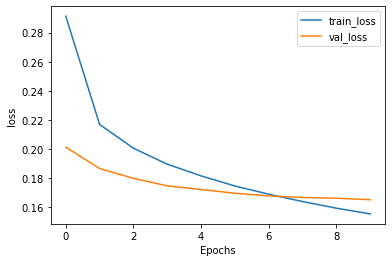

In [46]:
plot_graphs(hist_loss, val_hist_loss, 'loss')

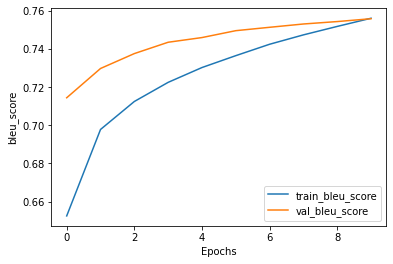

In [47]:
plot_graphs(hist_bleu_scores, val_hist_bleu_scores, 'bleu_score')

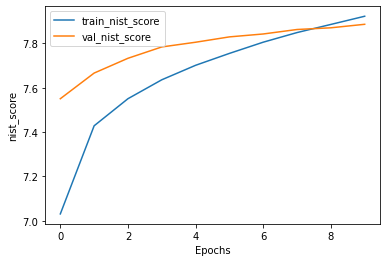

In [48]:
plot_graphs(hist_nist_scores, val_hist_nist_scores, 'nist_score')

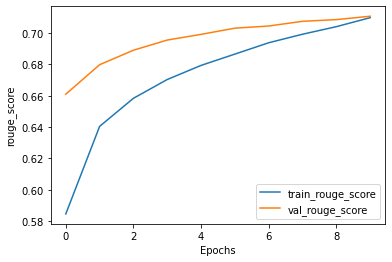

In [49]:
plot_graphs(hist_rouge_scores, val_hist_rouge_scores, 'rouge_score')

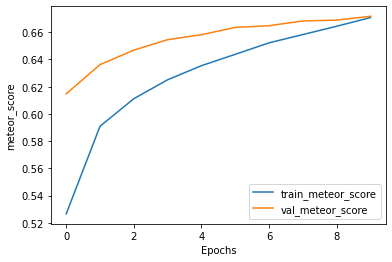

In [50]:
plot_graphs(hist_meteor_scores, val_hist_meteor_scores, 'meteor_score')